In [1]:
import drawing
import numpy as np

import os

import torch 
from torch import tensor
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
import matplotlib.pyplot as plt

import torch.nn.functional as F

import time

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

device = 'cuda:1' if torch.cuda.is_available() else 'cpu'
print(device)

n_mixtures = 3
hidden_size = 900
input_size = 3
batch_size = 256
n_epochs = 1000
max_length = 1200
lr = 1e-3
model_name = "20210810_BorrowRiteshNLL"


cuda:1


In [2]:
a = torch.zeros(2, 10) + 3
a[0, 7:] = 0
a[1, 5:] = 0
a
lengths = torch.tensor([7, 5])
p = pack_padded_sequence(a, lengths.cpu().numpy(), batch_first=True)


tensor([[3., 3., 3., 3., 3., 3., 3., 0., 0., 0.],
        [3., 3., 3., 3., 3., 0., 0., 0., 0., 0.]])

In [3]:
data_dir = "data"
data = [np.load(os.path.join(data_dir, '{}.npy'.format(i))) for i in ['x', 'x_len', 'c', 'c_len', 'w_id']]
strokes_og = data[0]
stroke_lens = data[1]
strings = data[2]
string_lens = data[3]
w_id = data[4]

In [4]:
# plt.plot(sorted(stroke_lens))
# plt.show()
# x = strokes_og[:,:,0].flatten()
# x = x[x!=0]
# x = x[x<5]
# x = x[x>-5]
# x = np.array(sorted(x))
# x.shape
# plt.plot(x)
# plt.show()
# plt.plot(np.log(x))
# plt.show()
# _=plt.hist(x, bins=100)
# plt.show()
# y = strokes_og[:,:,1].flatten()
# y = y[y!=0]
# y = y[y<5]
# y = y[y>-5]
# y = np.array(sorted(y))
# y.shape
# plt.plot(y)
# plt.show()
# plt.plot(np.log(y))
# plt.show()
# _=plt.hist(y, bins=100)

In [5]:
def standarize(strokes, lengths):
    points_to_consider = np.zeros((lengths.sum() - 2*len(lengths), 2))
    idx = 0
    for i in range(0, len(lengths)):
        #print(strokes[i][1:lengths[i], 0:2].shape)
        points_to_consider[idx:idx+lengths[i]-2] = strokes[i][1:lengths[i]-1, 0:2]
        idx += lengths[i] - 2
    means = points_to_consider.mean(axis=0)
    std = points_to_consider.std(axis=0)
    
    result = strokes.copy()
    for i in range(len(lengths)):
        result[i, 1:lengths[i]-1, 0:2] -= means
        result[i, 1:lengths[i]-1, 0:2] /= std
    return result, means, std

def destandarize(strokes_standarized, lengths, means, std):
    result = strokes_standarized.copy()
    for i in range(len(lengths)):
        result[i, 1:lengths[i]-1, 0:2] *= std
        result[i, 1:lengths[i]-1, 0:2] += means
    return result

def preprocess(strokes_og, stroke_lens, strings, string_lengths):
    # My preprocesisng is simple - all strokes start with (0, 0, 0) nd end with (0, 0, 1)

    # to this end we remove all full length strokes to make space for the end 
    # (0, 0, 1) as the end point

    indices = stroke_lens != 1200
    strokes_og = strokes_og[indices]
    stroke_lens = stroke_lens[indices]
    strings = strings[indices]
    string_lengths = string_lengths[indices]

    # Now we make sure that every stroke has the correct 
    # start point of (0, 0, 0) and end point of (0, 0, 1)
    strokes_og[:,0,2] = 0
    for i in range(strokes_og.shape[0]):
        strokes_og[i, stroke_lens[i], 2] = 1
    stroke_lens += 1
    
    # Standarize the coordinates separaetly to have zero mean and std dev 1
    standarized_strokes, means, std = standarize(strokes_og, stroke_lens)
    
    return standarized_strokes, means, std, stroke_lens, strings, string_lengths



In [6]:
strokes, means, std, stroke_lengths, strings, string_lengths  = preprocess(
    strokes_og, stroke_lens, strings, string_lens)
print(strokes.shape, stroke_lengths.shape, means.shape, std.shape, strings.shape, string_lengths.shape)


(11846, 1200, 3) (11846,) (2,) (2,) (11846, 75) (11846,)


In [7]:
strokes[2][stroke_lengths[2]-2:stroke_lengths[2]+2]

array([[-0.61420643, -0.1501907 ,  1.        ],
       [ 0.        ,  0.        ,  1.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ]], dtype=float32)

In [8]:
import matplotlib.pyplot as plt

def offsets_to_coords(offsets):
    """
    convert from offsets to coordinates
    """
    return np.concatenate([np.cumsum(offsets[:, :2], axis=0), offsets[:, 2:3]], axis=1)


def draw(offsets, plot_end_points=True):
    strokes = offsets_to_coords(offsets)
    
    fig, ax = plt.subplots(figsize=(12, 6))
    stroke = []
    for x, y, eos in strokes:
        stroke.append((x, y))
        if eos == 1:
            coords = list(zip(*stroke))
            ax.plot(coords[0], coords[1], 'k')
            if plot_end_points:
                ax.plot(x, y, 'ro')
            stroke = []
    if stroke:
        coords = list(zip(*stroke))
        ax.plot(coords[0], coords[1], 'k')
        stroke = []

    padding = 10
    
    ax.set_xlim(strokes[:,0].min() - padding, strokes[:,0].max() + padding)
    ax.set_ylim(strokes[:,1].min() - padding, strokes[:,1].max() + padding)

    ax.set_aspect('equal')
    plt.tick_params(
        axis='both',
        left='off',
        top='off',
        right='off',
        bottom='off',
        labelleft='off',
        labeltop='off',
        labelright='off',
        labelbottom='off'
    )
    plt.show()
    plt.close('all')

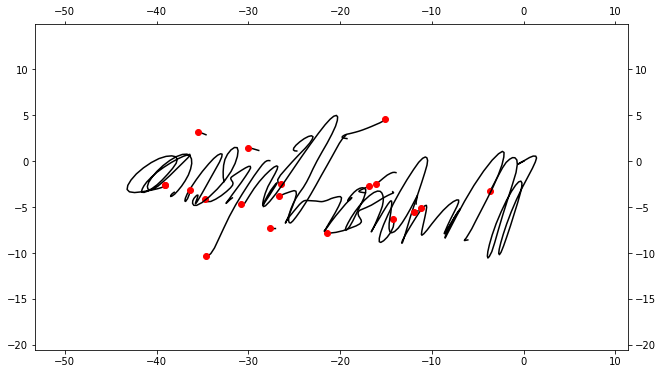

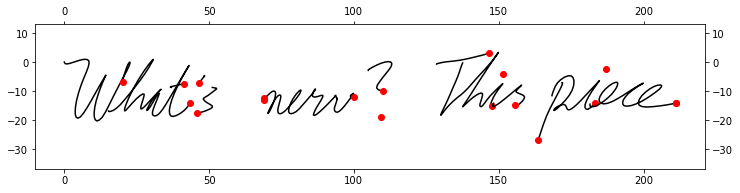

What 's new? This piece


In [9]:
draw(strokes[0])
res2 = destandarize(strokes, stroke_lengths, means, std) # for checking
draw(res2[0])
print(drawing.decode_ascii(strings[0]))

In [10]:
class HandwritingDataset(Dataset):
    def __init__(self, strokes, stroke_lengths):
        self.strokes = strokes
        self.stroke_lengths = stroke_lengths
        #self.mask = self.getMask()
        
    def __len__(self):
        return self.strokes.shape[0]
    
    def __getitem__(self, idx):
        return self.strokes[idx], self.stroke_lengths[idx] #, self.mask[idx]
    
    def getMask(self):
        mask = np.ones((self.strokes.shape[0], self.strokes.shape[1]))
        for i in range(self.strokes.shape[0]):
            # The mask needs to be 1 not till the last index or the index corresponding 
            # to the last character of stroke, but instead one before as the last char is 
            # always a special character (0, 0, 1) denoting the end of the stroke and 
            # we do not want to include loss computation on this as there is no point 
            # in teh stroke after this.
            mask[i][self.stroke_lengths[i]-1:] = 0
        return mask
    
train_dataset = HandwritingDataset(strokes[:10000], stroke_lens[:10000])
test_dataset = HandwritingDataset(strokes[10000:], stroke_lens[10000:])


In [11]:
class Prediction(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Prediction, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.lstmLayer = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.linearLayer = nn.Linear(input_size+hidden_size, output_size)
        
    def forward(self, packed_input, h0, c0):
        packed_out1, (hn, cn) = self.lstmLayer(packed_input, (h0, c0))
        
        lin_layer_input = torch.cat(
            (packed_input.data, packed_out1.data), dim=-1)
        return self.linearLayer(lin_layer_input), (hn, cn)

In [12]:
a = torch.randn(3, 2)
a.unbind(-1)

(tensor([0.1699, 0.4887, 2.0591]), tensor([0.1525, 0.7485, 0.3055]))

In [13]:
# From Ritesh

def mixture_of_bivariate_normal_nll(
    data, log_pi, mu, log_sigma, rho, eps=1e-6
):
    x, y, _ = data.unbind(-1)
    x = x.unsqueeze(1).repeat_interleave(
            torch.tensor([n_mixtures], device=device), dim=-1)
    y = y.unsqueeze(1).repeat_interleave(
            torch.tensor([n_mixtures], device=device), dim=-1)
    mu_1, mu_2 = mu.unbind(-1)

    log_sigma_1, log_sigma_2 = log_sigma.unbind(-1)
    sigma_1 = log_sigma_1.exp() + eps
    sigma_2 = log_sigma_2.exp() + eps

    # Compute log prob of bivariate normal distribution
    Z = torch.pow((x - mu_1) / sigma_1, 2) + torch.pow((y - mu_2) / sigma_2, 2)
    Z -= 2 * rho * ((x - mu_1) * (y - mu_2)) / (sigma_1 * sigma_2)

    log_N = -Z / (2 * (1 - rho ** 2) + eps)
    log_N -= np.log(2 * np.pi) + log_sigma_1 + log_sigma_2
    log_N -= .5 * torch.log(1 - rho ** 2 + eps)

    # Use log_sum_exp to accurately compute log prob of mixture distribution
    nll = -torch.logsumexp(log_pi + log_N, dim=-1)
    return nll.sum()/data.shape[0]


def mixture_of_bivariate_normal_sample(
    log_pi, mu, log_sigma, rho, eps=1e-6, bias=0.
):
    batch_size = log_pi.shape[0]
    ndims = log_pi.dim()

    if ndims > 2:
        # Collapse batch and seq_len dimensions
        log_pi, mu, log_sigma, rho = [
            x.reshape(-1, *x.shape[2:])
            for x in [log_pi, mu, log_sigma, rho]
        ]

    # Sample mixture index using mixture probabilities pi
    pi = log_pi.exp() * (1 + bias)
    mixture_idx = pi.multinomial(1).squeeze(1)

    # Index the correct mixture for mu, log_sigma and rho
    mu, log_sigma, rho = [
        x[torch.arange(mixture_idx.shape[0]), mixture_idx]
        for x in [mu, log_sigma, rho]
    ]

    # Calculate biased variances
    sigma = (log_sigma - bias).exp()

    # Sample from the bivariate normal distribution
    mu_1, mu_2 = mu.unbind(-1)
    sigma_1, sigma_2 = sigma.unbind(-1)
    z_1 = torch.randn_like(mu_1)
    z_2 = torch.randn_like(mu_2)

    x = mu_1 + sigma_1 * z_1
    y = mu_2 + sigma_2 * (z_2 * ((1 - rho ** 2) ** .5) + z_1 * rho)

    # Uncollapse the matrix to a tensor (if necessary)
    sample = torch.stack([x, y], 1)
    if ndims > 2:
        sample = sample.view(batch_size, -1, 2)

    return sample

def parse_outputs(out):
        K = n_mixtures
        mu, log_sigma, pi, rho, eos = out.split([2 * K, 2 * K, K, K, 1], -1)

        # Apply activations to constrain values in the correct range
        rho = torch.tanh(rho)
        log_pi = F.log_softmax(pi, dim=-1)
        eos = torch.sigmoid(-eos)

        mu = mu.view(mu.shape[:-1] + (K, 2))
        log_sigma = log_sigma.view(log_sigma.shape[:-1] + (K, 2))

        return log_pi, mu, log_sigma, rho, eos


In [14]:
def get_next_point(model, point_prev, h_prev, c_prev):
    with torch.no_grad():
        model_input = pack_padded_sequence(
            point_prev.unsqueeze(0).unsqueeze(0),
            torch.tensor([1]).cpu().numpy(),
            batch_first=True)
        outputs, (h_next, c_next) = model(model_input, h_prev, c_prev)
        
        log_pi, mu, log_sigma, rho, eos = parse_outputs(outputs)
        sample = mixture_of_bivariate_normal_sample(log_pi, mu, log_sigma, rho)
        sample = torch.cat([sample,
                eos.bernoulli()
            ], dim=1)[0]
        return sample.to(device), (h_next, c_next)
        
def sample(model):
    timestamps = max_length
    sample_stroke = torch.zeros(timestamps, 3, device=device)
    h = torch.zeros(1, 1, hidden_size, device=device)
    c = torch.zeros(1, 1, hidden_size, device=device)
    stroke_end = False
    for i in range(timestamps-2):
        prev_point = sample_stroke[i]
        new_point, (h, c) = get_next_point(model, prev_point, h, c)
        sample_stroke[i+1] = new_point
        if(new_point[0] == 0 and new_point[1] == 0 and new_point[2] == 1):
            print("Model decided to end the stroke")
            stroke_end = True
            break
    if (not stroke_end):
        sample_stroke[timestamps-1][2] = 1
    return sample_stroke

In [15]:
def get_inputs_targets_from_batch(strokes_batch, lengths_batch):
    lengths_batch, perm_idx = lengths_batch.sort(0, descending=True)
    strokes_batch = strokes_batch[perm_idx]
    
    packed_inputs = pack_padded_sequence(
        strokes_batch,
        lengths_batch.cpu().numpy() - 1, # we dont want to pack the entire sequence
        batch_first=True)
    targets = pack_padded_sequence(
        strokes_batch[:,1:,:],
        lengths_batch.cpu().numpy() - 1, # we dont want to pack the entire sequence
        batch_first=True)
    return packed_inputs, targets

def train_batch(model, optimizer, strokes_batch, lengths_batch, h0, c0):
    optimizer.zero_grad()
    inputs, targets = get_inputs_targets_from_batch(strokes_batch, lengths_batch)
    outputs, _ = model(inputs, h0, c0)
    log_pi, mu, log_sigma, rho, eos = parse_outputs(outputs)
    loss = mixture_of_bivariate_normal_nll(
        targets.data, log_pi, mu, log_sigma, rho)
    loss.backward()
    #### Do Gradient clipping here if need be
    optimizer.step()
    return loss.item()

def save_model(model, model_name):
    base_dir = "/u/home/lyrebird_code/handwriting_synthesis/model_checkpoints/"
    torch.save({
        'model_state_dict': model.state_dict(),
    }, base_dir + model_name)
    
def train(model, optimizer, train_dataloader, num_epochs):
    losses = []
    n_iter = 0
    total_loss = 0
    start = time.time()
    
    print_every = 50
    sample_every = print_every * 5
    
    h0 = torch.zeros(1, batch_size, hidden_size, device=device)
    c0 = torch.zeros(1, batch_size, hidden_size, device=device)
    
    for epoch in range(num_epochs):
        
        for strokes_batch, lengths_batch in train_dataloader:
            strokes_batch = strokes_batch.to(device)
            lengths_batch = lengths_batch.to(device)
            
            batch_loss = train_batch(
                model,
                optimizer,
                strokes_batch,
                lengths_batch,
                h0, c0)
            h0 = h0.detach()
            c0 = c0.detach()
            total_loss += batch_loss
            
            if n_iter % print_every == 0:
                avg_loss = total_loss/print_every
                losses.append(avg_loss)
                print(f"iteration: {n_iter} "\
                      f"of {len(train_dataloader) * num_epochs}, " \
                      f"avg_loss: {avg_loss:.2f}, "\
                      f"timeSinceStart: {time.time() - start :.2f}, "\
                      f"Epoch: {epoch}")
                total_loss = 0
                save_model(model, model_name)
                
            if n_iter % sample_every == 0:
                sample_stroke = sample(model)
                sample_stroke[1:, 0:2] *= torch.tensor(std, device=device)
                sample_stroke[1:, 0:2] += torch.tensor(means, device=device)
                draw(sample_stroke.cpu(), plot_end_points=False)
                
            n_iter += 1
    return losses

In [16]:

model = Prediction(input_size, hidden_size, 6*n_mixtures+1).to(device)
optim = torch.optim.Adam(model.parameters(), lr = lr)
train_dataloader = DataLoader(
    train_dataset,
    shuffle=True,
    batch_size=batch_size,
    drop_last=True)


iteration: 0 of 39000, avg_loss: 0.05, timeSinceStart: 2.34, Epoch: 0


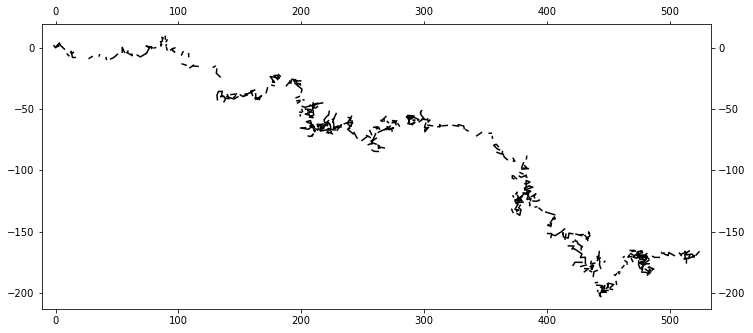

iteration: 50 of 39000, avg_loss: 2.03, timeSinceStart: 35.50, Epoch: 1
iteration: 100 of 39000, avg_loss: 0.17, timeSinceStart: 66.95, Epoch: 2
iteration: 150 of 39000, avg_loss: -1.17, timeSinceStart: 98.49, Epoch: 3
iteration: 200 of 39000, avg_loss: -1.81, timeSinceStart: 130.06, Epoch: 5
iteration: 250 of 39000, avg_loss: -2.34, timeSinceStart: 161.82, Epoch: 6


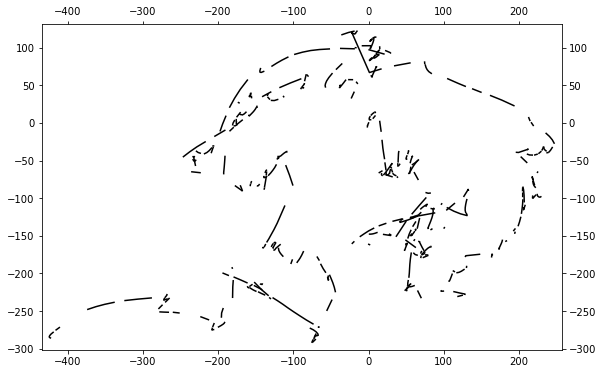

iteration: 300 of 39000, avg_loss: -2.68, timeSinceStart: 194.84, Epoch: 7
iteration: 350 of 39000, avg_loss: -2.67, timeSinceStart: 226.35, Epoch: 8
iteration: 400 of 39000, avg_loss: -2.24, timeSinceStart: 257.97, Epoch: 10
iteration: 450 of 39000, avg_loss: -2.87, timeSinceStart: 289.51, Epoch: 11
iteration: 500 of 39000, avg_loss: -2.68, timeSinceStart: 320.93, Epoch: 12


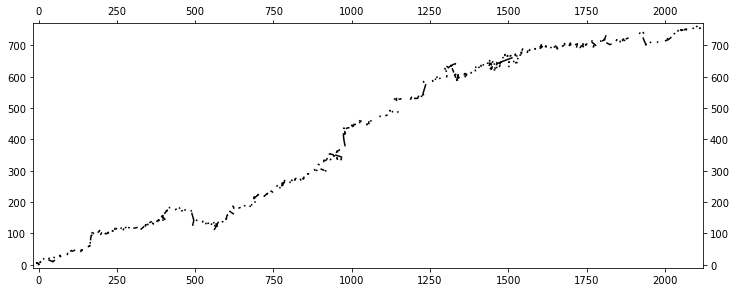

iteration: 550 of 39000, avg_loss: -2.48, timeSinceStart: 354.10, Epoch: 14
iteration: 600 of 39000, avg_loss: -2.84, timeSinceStart: 385.62, Epoch: 15
iteration: 650 of 39000, avg_loss: -2.63, timeSinceStart: 417.14, Epoch: 16
iteration: 700 of 39000, avg_loss: -2.98, timeSinceStart: 448.57, Epoch: 17
iteration: 750 of 39000, avg_loss: -2.91, timeSinceStart: 479.99, Epoch: 19


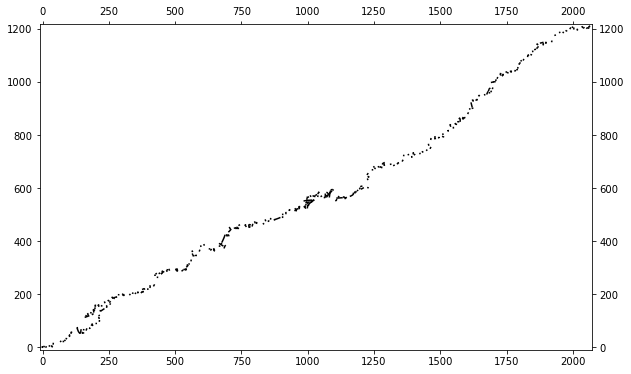

iteration: 800 of 39000, avg_loss: -2.78, timeSinceStart: 513.17, Epoch: 20
iteration: 850 of 39000, avg_loss: -2.95, timeSinceStart: 544.68, Epoch: 21
iteration: 900 of 39000, avg_loss: -2.95, timeSinceStart: 576.14, Epoch: 23
iteration: 950 of 39000, avg_loss: -2.53, timeSinceStart: 607.56, Epoch: 24
iteration: 1000 of 39000, avg_loss: -2.99, timeSinceStart: 639.11, Epoch: 25


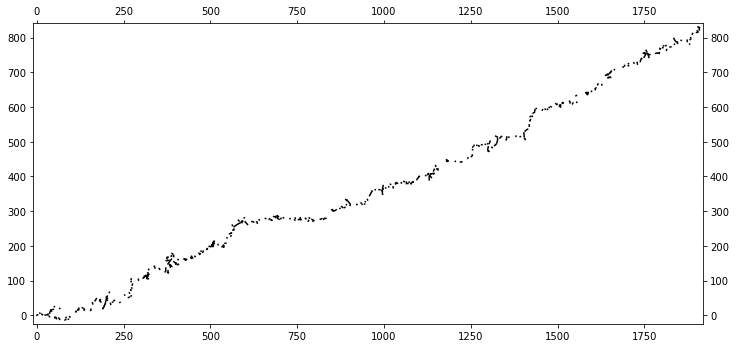

iteration: 1050 of 39000, avg_loss: -3.07, timeSinceStart: 672.52, Epoch: 26
iteration: 1100 of 39000, avg_loss: -2.83, timeSinceStart: 703.97, Epoch: 28
iteration: 1150 of 39000, avg_loss: -2.96, timeSinceStart: 735.52, Epoch: 29
iteration: 1200 of 39000, avg_loss: -3.03, timeSinceStart: 767.05, Epoch: 30
iteration: 1250 of 39000, avg_loss: -3.34, timeSinceStart: 798.56, Epoch: 32


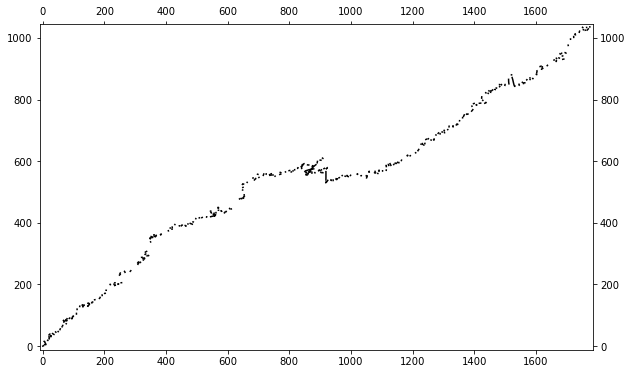

iteration: 1300 of 39000, avg_loss: -2.79, timeSinceStart: 831.75, Epoch: 33
iteration: 1350 of 39000, avg_loss: -2.88, timeSinceStart: 863.21, Epoch: 34
iteration: 1400 of 39000, avg_loss: -3.18, timeSinceStart: 894.69, Epoch: 35
iteration: 1450 of 39000, avg_loss: -3.11, timeSinceStart: 926.16, Epoch: 37
iteration: 1500 of 39000, avg_loss: -3.16, timeSinceStart: 957.68, Epoch: 38


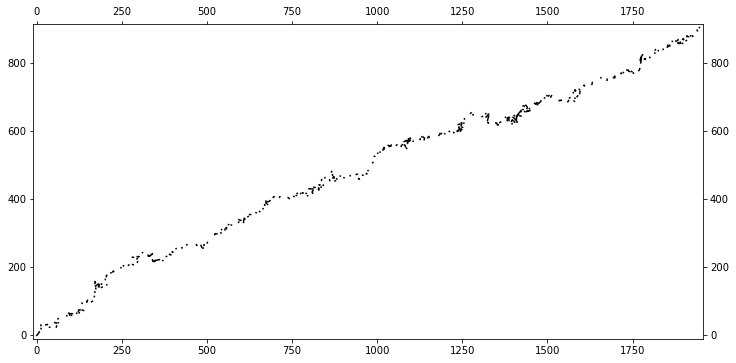

iteration: 1550 of 39000, avg_loss: -2.74, timeSinceStart: 990.78, Epoch: 39
iteration: 1600 of 39000, avg_loss: -2.70, timeSinceStart: 1022.29, Epoch: 41
iteration: 1650 of 39000, avg_loss: -2.84, timeSinceStart: 1053.86, Epoch: 42
iteration: 1700 of 39000, avg_loss: -2.98, timeSinceStart: 1085.32, Epoch: 43
iteration: 1750 of 39000, avg_loss: -3.21, timeSinceStart: 1116.77, Epoch: 44


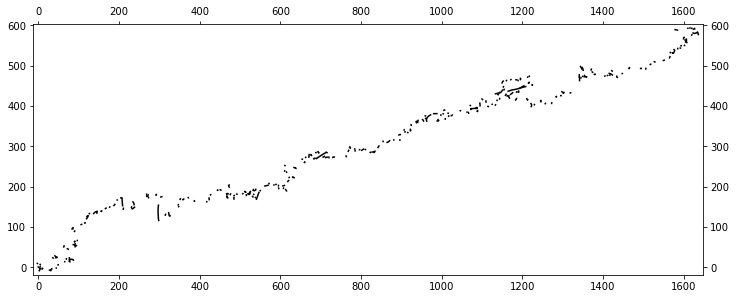

iteration: 1800 of 39000, avg_loss: -3.27, timeSinceStart: 1150.05, Epoch: 46
iteration: 1850 of 39000, avg_loss: -2.81, timeSinceStart: 1181.54, Epoch: 47
iteration: 1900 of 39000, avg_loss: -2.72, timeSinceStart: 1213.10, Epoch: 48
iteration: 1950 of 39000, avg_loss: -2.89, timeSinceStart: 1244.62, Epoch: 50
iteration: 2000 of 39000, avg_loss: -3.25, timeSinceStart: 1276.15, Epoch: 51


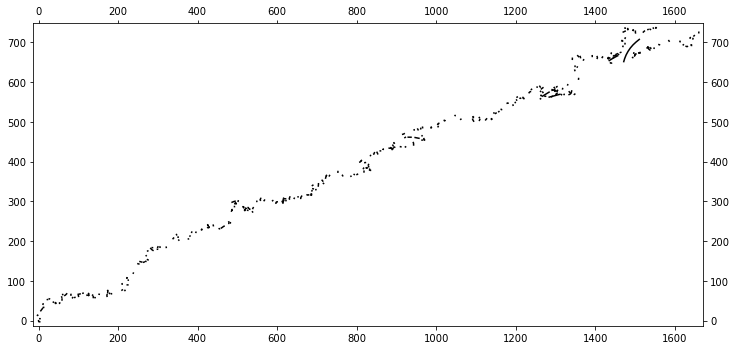

iteration: 2050 of 39000, avg_loss: -3.33, timeSinceStart: 1309.36, Epoch: 52
iteration: 2100 of 39000, avg_loss: -2.79, timeSinceStart: 1340.83, Epoch: 53
iteration: 2150 of 39000, avg_loss: -2.71, timeSinceStart: 1372.39, Epoch: 55
iteration: 2200 of 39000, avg_loss: -3.02, timeSinceStart: 1403.88, Epoch: 56
iteration: 2250 of 39000, avg_loss: -2.89, timeSinceStart: 1435.28, Epoch: 57


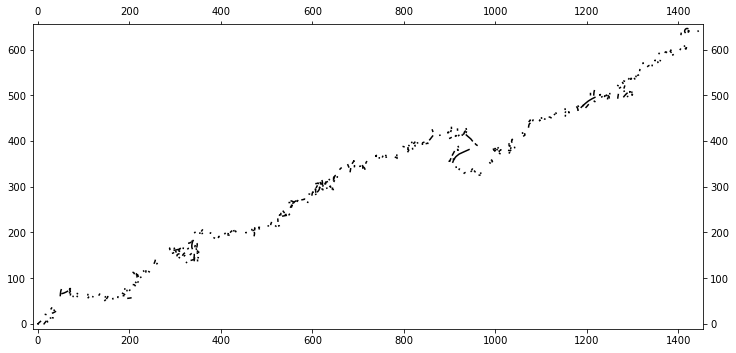

iteration: 2300 of 39000, avg_loss: -2.96, timeSinceStart: 1468.55, Epoch: 58
iteration: 2350 of 39000, avg_loss: -2.89, timeSinceStart: 1500.07, Epoch: 60
iteration: 2400 of 39000, avg_loss: -3.14, timeSinceStart: 1531.50, Epoch: 61
iteration: 2450 of 39000, avg_loss: -2.83, timeSinceStart: 1562.98, Epoch: 62
iteration: 2500 of 39000, avg_loss: -3.33, timeSinceStart: 1594.52, Epoch: 64


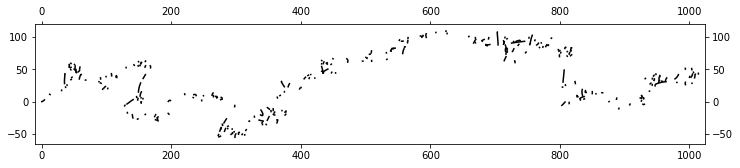

iteration: 2550 of 39000, avg_loss: -2.96, timeSinceStart: 1627.72, Epoch: 65
iteration: 2600 of 39000, avg_loss: -2.96, timeSinceStart: 1659.27, Epoch: 66
iteration: 2650 of 39000, avg_loss: -2.98, timeSinceStart: 1690.78, Epoch: 67
iteration: 2700 of 39000, avg_loss: -3.44, timeSinceStart: 1722.33, Epoch: 69
iteration: 2750 of 39000, avg_loss: -3.07, timeSinceStart: 1753.78, Epoch: 70


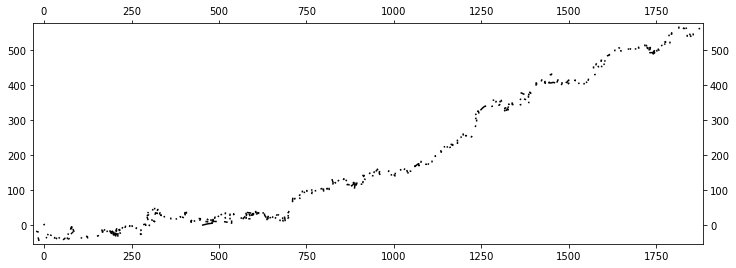

iteration: 2800 of 39000, avg_loss: -2.36, timeSinceStart: 1786.78, Epoch: 71
iteration: 2850 of 39000, avg_loss: -3.05, timeSinceStart: 1818.26, Epoch: 73
iteration: 2900 of 39000, avg_loss: -2.75, timeSinceStart: 1849.73, Epoch: 74
iteration: 2950 of 39000, avg_loss: -2.88, timeSinceStart: 1881.27, Epoch: 75
iteration: 3000 of 39000, avg_loss: -3.31, timeSinceStart: 1912.81, Epoch: 76


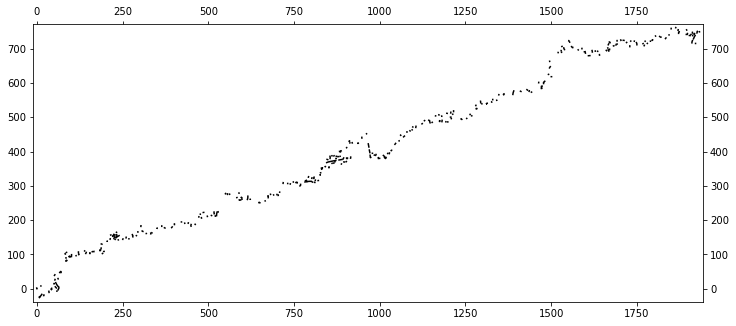

iteration: 3050 of 39000, avg_loss: -2.49, timeSinceStart: 1946.04, Epoch: 78
iteration: 3100 of 39000, avg_loss: -3.03, timeSinceStart: 1977.59, Epoch: 79
iteration: 3150 of 39000, avg_loss: -2.95, timeSinceStart: 2009.05, Epoch: 80
iteration: 3200 of 39000, avg_loss: -2.75, timeSinceStart: 2040.59, Epoch: 82
iteration: 3250 of 39000, avg_loss: -3.16, timeSinceStart: 2072.13, Epoch: 83


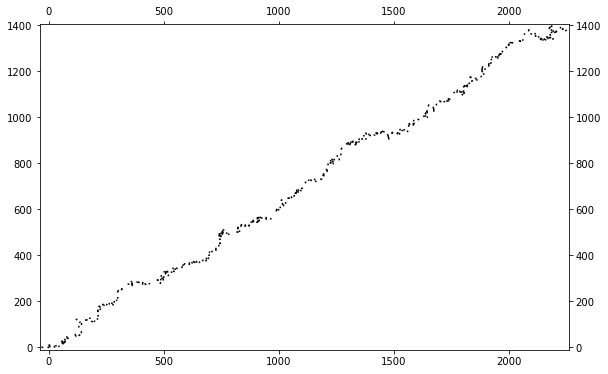

iteration: 3300 of 39000, avg_loss: -3.06, timeSinceStart: 2105.27, Epoch: 84
iteration: 3350 of 39000, avg_loss: -3.56, timeSinceStart: 2136.70, Epoch: 85
iteration: 3400 of 39000, avg_loss: -2.51, timeSinceStart: 2168.11, Epoch: 87
iteration: 3450 of 39000, avg_loss: -2.71, timeSinceStart: 2199.64, Epoch: 88
iteration: 3500 of 39000, avg_loss: -2.96, timeSinceStart: 2231.21, Epoch: 89


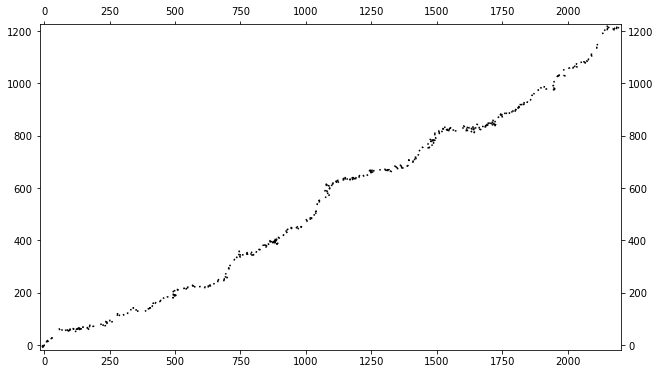

iteration: 3550 of 39000, avg_loss: -2.93, timeSinceStart: 2264.37, Epoch: 91
iteration: 3600 of 39000, avg_loss: -3.16, timeSinceStart: 2295.92, Epoch: 92
iteration: 3650 of 39000, avg_loss: -3.57, timeSinceStart: 2327.45, Epoch: 93
iteration: 3700 of 39000, avg_loss: -3.22, timeSinceStart: 2359.06, Epoch: 94
iteration: 3750 of 39000, avg_loss: -2.53, timeSinceStart: 2390.64, Epoch: 96


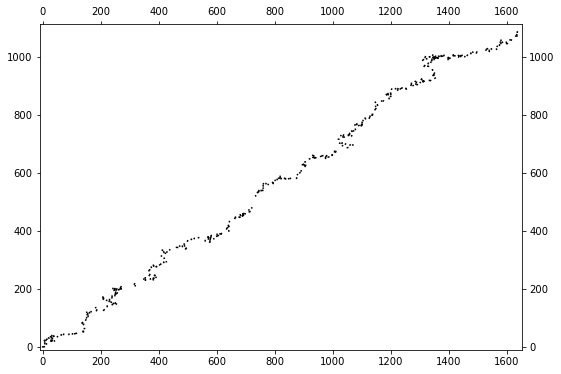

iteration: 3800 of 39000, avg_loss: -2.75, timeSinceStart: 2423.80, Epoch: 97
iteration: 3850 of 39000, avg_loss: -2.78, timeSinceStart: 2455.25, Epoch: 98
iteration: 3900 of 39000, avg_loss: -3.01, timeSinceStart: 2486.96, Epoch: 100
iteration: 3950 of 39000, avg_loss: -3.15, timeSinceStart: 2518.45, Epoch: 101
iteration: 4000 of 39000, avg_loss: -3.31, timeSinceStart: 2549.93, Epoch: 102


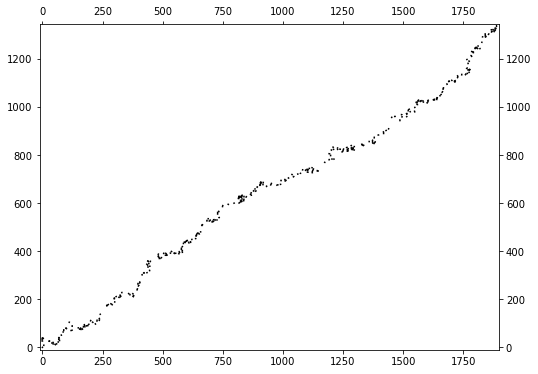

iteration: 4050 of 39000, avg_loss: -3.09, timeSinceStart: 2583.03, Epoch: 103
iteration: 4100 of 39000, avg_loss: -2.78, timeSinceStart: 2614.51, Epoch: 105
iteration: 4150 of 39000, avg_loss: -3.43, timeSinceStart: 2645.98, Epoch: 106
iteration: 4200 of 39000, avg_loss: -2.90, timeSinceStart: 2677.54, Epoch: 107
iteration: 4250 of 39000, avg_loss: -2.83, timeSinceStart: 2709.02, Epoch: 108


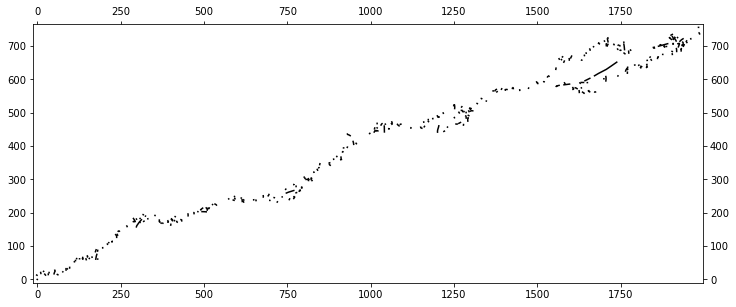

iteration: 4300 of 39000, avg_loss: -3.41, timeSinceStart: 2742.14, Epoch: 110
iteration: 4350 of 39000, avg_loss: -2.69, timeSinceStart: 2773.60, Epoch: 111
iteration: 4400 of 39000, avg_loss: -3.29, timeSinceStart: 2805.11, Epoch: 112
iteration: 4450 of 39000, avg_loss: -3.26, timeSinceStart: 2836.62, Epoch: 114
iteration: 4500 of 39000, avg_loss: -3.40, timeSinceStart: 2868.07, Epoch: 115


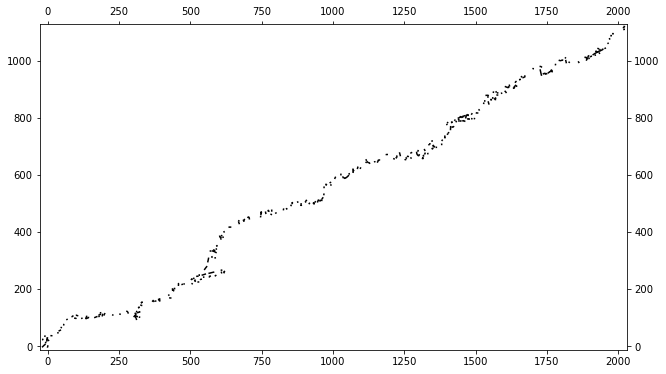

iteration: 4550 of 39000, avg_loss: -2.93, timeSinceStart: 2901.30, Epoch: 116
iteration: 4600 of 39000, avg_loss: -3.51, timeSinceStart: 2932.79, Epoch: 117
iteration: 4650 of 39000, avg_loss: -2.90, timeSinceStart: 2964.35, Epoch: 119
iteration: 4700 of 39000, avg_loss: -3.15, timeSinceStart: 2995.84, Epoch: 120
iteration: 4750 of 39000, avg_loss: -3.25, timeSinceStart: 3027.35, Epoch: 121


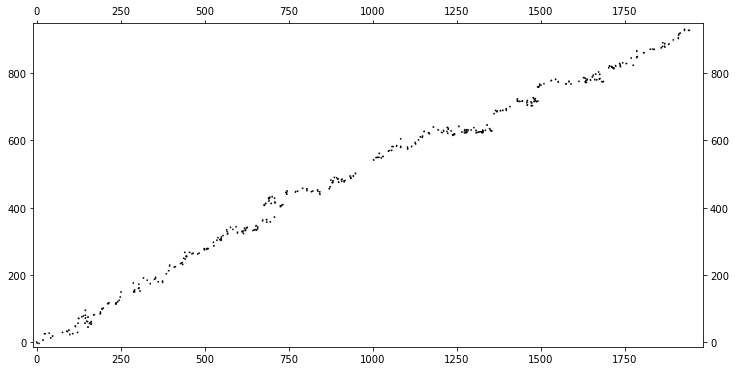

iteration: 4800 of 39000, avg_loss: -3.08, timeSinceStart: 3060.57, Epoch: 123
iteration: 4850 of 39000, avg_loss: -3.11, timeSinceStart: 3092.05, Epoch: 124
iteration: 4900 of 39000, avg_loss: -3.07, timeSinceStart: 3123.60, Epoch: 125
iteration: 4950 of 39000, avg_loss: -3.29, timeSinceStart: 3155.08, Epoch: 126
iteration: 5000 of 39000, avg_loss: -3.25, timeSinceStart: 3186.60, Epoch: 128


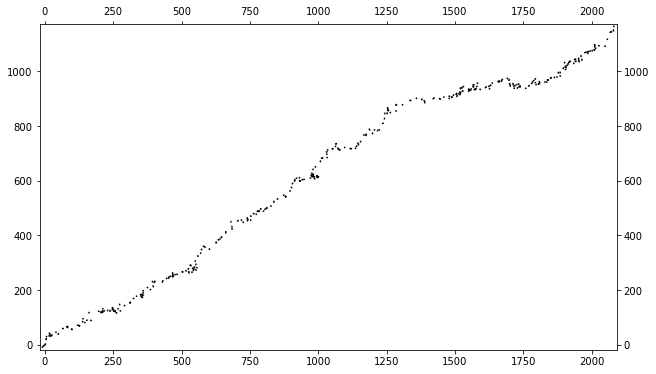

iteration: 5050 of 39000, avg_loss: -3.17, timeSinceStart: 3219.85, Epoch: 129
iteration: 5100 of 39000, avg_loss: -3.34, timeSinceStart: 3251.37, Epoch: 130
iteration: 5150 of 39000, avg_loss: -3.15, timeSinceStart: 3282.91, Epoch: 132
iteration: 5200 of 39000, avg_loss: -3.47, timeSinceStart: 3314.50, Epoch: 133
iteration: 5250 of 39000, avg_loss: -0.32, timeSinceStart: 3346.10, Epoch: 134


RuntimeError: probability tensor contains either `inf`, `nan` or element < 0

In [17]:
train(model, optim, train_dataloader, n_epochs)

In [ ]:
m = Prediction(input_size, hidden_size, 6*n_mixtures+1).to(device)

inputs = torch.randn(batch_size, max_length, input_size, device=device)
inputs[:,0, 0:3] = 0
inputs[0,4, 0:2] = 0
inputs[0,1:5, 2] = 0
inputs[0,4, 2] = 1

inputs[1,3:, 0:3] = 0
inputs[1,2, 0:2] = 0
inputs[1,2, 2] = 1
inputs[1,1, 2] = 0
inputs

lengths = torch.tensor([5, 3])

packed_inp = pack_padded_sequence(
    inputs,
    lengths.cpu().numpy() - 1, # we dont want to pack the entire sequence
    batch_first=True)
targets = pack_padded_sequence(
    inputs[:,1:,:],
    lengths.cpu().numpy() - 1, # we dont want to pack the entire sequence
    batch_first=True)
packed_inp
targets
h = torch.zeros(1, 2, 4, device=device)
out, out1 = m(packed_inp, h, h)
print("out", out)
nll(out, targets.data)
print(out1)

In [ ]:
h0 = torch.zeros(1, batch_size, hidden_size, device=device)
c0 = torch.zeros(1, batch_size, hidden_size, device=device)
print(inputs.shape, lengths.shape, lengths)
train_batch(m, optim, inputs, lengths, h0, c0)
s = sample(m)
draw(s.cpu())

In [ ]:
start = torch.tensor([0, 0, 0])


In [ ]:
inputs = torch.randn(2, 5, 3)
inputs[:,0, 0:3] = 0
inputs[0,4, 0:2] = 0
inputs[0,1:5, 2] = 0
inputs[0,4, 2] = 1

inputs[1,3:, 0:3] = 0
inputs[1,2, 0:2] = 0
inputs[1,2, 2] = 1
inputs[1,1, 2] = 0
inputs
lengths = torch.tensor([5, 3])
lengths
ps = pack_padded_sequence(
            inputs,
            lengths.cpu().numpy() - 1, # we dont want to pack the entire sequence
            batch_first=True)
lstmLayer = nn.LSTM(3, 4, batch_first=True)
linLayer = nn.Linear(4, 7)


lstmout, _ = lstmLayer(ps)
lstmout
torch.cat((ps.data,lstmout.data), dim=-1)
linLayer(lstmLayer(ps)[0][0])
pad_packed_sequence(lstmLayer(ps)[0], batch_first=True)
